<a href="https://colab.research.google.com/github/REILLLx/new/blob/master/Kaushan_WS1_Regression_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Інформація про датасет

**Інформація про набір даних:**<br>
Набір даних містить 9358 усереднених за годину відповідей від масиву з 5 хімічних датчиків оксиду металу, вбудованих у хімічний мультисенсорний пристрій якості повітря. Апарат був розташований на полі в сильно забрудненому районі, на рівні дороги, в межах італійського міста. Дані були записані з березня 2004 р. по лютий 2005 р. (один рік), що представляє собою найдовші доступні у вільному доступі записи відповідей хімічних датчиків якості повітря, розміщених у полі. Ground Truth усереднені за годину концентрації CO, неметанових вуглеводнів, бензолу, загальних оксидів азоту (NOx) і діоксиду азоту (NO2) були надані суміжним еталонним сертифікованим аналізатором. <br>Відсутні значення позначено значенням -200.<br>
Інформація про атрибути:<br>

0. Date - Дата (ДД/ММ/РРРР)
1. Time - Час (ГГ.ХХ.СС)
2. CO(GT) Справжня середньогодинна концентрація СО в мг/м^3 (еталонний аналізатор)
3. PT08.S1 (оксид олова) усереднена за годину відповідь датчика (номінально цільовий CO)
4. NMHC(GT) - Справжня середньогодинна загальна концентрація неметанових вуглеводнів у мкг/м^3 (еталонний аналізатор)
5. C6H6(GT) - Справжня середньогодинна концентрація бензолу в мкг/м^3 (еталонний аналізатор)
6. PT08.S2 (titania) усереднена за годину відповідь датчика (номінально націлений NMHC)
7. NOx(GT) - Справжня середньогодинна концентрація NOx в ppb (еталонний аналізатор)
8. PT08.S3 (оксид вольфраму) погодинна усереднена відповідь датчика (номінально цільовий NOx)
9. NO2(GT) - Справжня середньогодинна концентрація NO2 в мкг/м^3 (еталонний аналізатор)
10. PT08.S4 (оксид вольфраму) погодинна усереднена відповідь датчика (номінально націлений NO2)
11. PT08.S5 (оксид індію) усереднена за годину відповідь датчика (номінально цільовий O3)
12. T - Температура в °C
13. RH - Відносна вологість (%)
14. AH - Абсолютна вологість



# Ініціалізація середовища

In [ ]:
# !pip install regressors

In [1]:
# init environment
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

import numpy as np
import pandas as pd
import scipy.stats as st
import math
import matplotlib.text as plttxt

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
plt.style.use('bmh')

from dateutil import parser

from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import r2_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RepeatedKFold, cross_validate
from sklearn.compose import TransformedTargetRegressor, make_column_transformer
from sklearn.metrics import PredictionErrorDisplay, median_absolute_error, mean_absolute_error
import scipy as sp
from sklearn.linear_model import RidgeCV, LassoCV
# from regressors.stats import coef_pval
%matplotlib inline

# Зчитування і форматування даних

In [2]:

file_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00360/AirQualityUCI.zip'
resp = urlopen(file_url)
zipfile = ZipFile(BytesIO(resp.read()))
data = zipfile.open('AirQualityUCI.csv')
df = pd.read_csv(data, sep=';')

In [ ]:
df.head(3)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN


In [3]:
# check empty rows and drop them
print('Initial shape: ' + str(df.shape))
print(df[df['Date'].isnull()])
df.dropna(how='all', inplace=True)
print('Result shape: ' + str(df.shape))

Initial shape: (9471, 17)
     Date Time CO(GT)  PT08.S1(CO)  NMHC(GT) C6H6(GT)  PT08.S2(NMHC)  NOx(GT)  \
9357  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9358  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9359  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9360  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9361  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
...   ...  ...    ...          ...       ...      ...            ...      ...   
9466  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9467  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9468  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9469  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   
9470  NaN  NaN    NaN          NaN       NaN      NaN            NaN      NaN   

 

In [4]:
# check if the last 2 columns has values
[df['Unnamed: 16'].unique(),  df['Unnamed: 16'].unique()]

[array([nan]), array([nan])]

In [5]:
# drop last 2 columns
df.drop(['Unnamed: 15', 'Unnamed: 16'], axis=1, inplace=True)
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578"
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255"
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502"
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867"
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888"


In [ ]:
# check data
df.dtypes

,0
Date,object
Time,object
CO(GT),object
PT08.S1(CO),float64
NMHC(GT),float64
C6H6(GT),object
PT08.S2(NMHC),float64
NOx(GT),float64
PT08.S3(NOx),float64
NO2(GT),float64


Як бачимо частина параметрів, що мала б бути числовими, такими не є. Виправимо це.

In [6]:
df['DateTime'] = (df['Date'] + ' ' + df['Time'].str.replace('.', ':')).map(parser.parse)
df['Date'] = df['Date'].map(parser.parse)
df['Hour'] = df['Time'].map(lambda x: int(x[0:2]))
df['C6H6(GT)'] = df['C6H6(GT)'].map(lambda x: float(x.replace(',','.')))
df['CO(GT)'] = df['CO(GT)'].map(lambda x: float(x.replace(',','.')))
df['T'] = df['T'].map(lambda x: float(x.replace(',','.')))
df['RH'] = df['RH'].map(lambda x: float(x.replace(',','.')))
df['AH'] = df['AH'].map(lambda x: float(x.replace(',','.')))

In [ ]:
df.dtypes

Date             datetime64[ns]
Time                     object
CO(GT)                  float64
PT08.S1(CO)             float64
NMHC(GT)                float64
C6H6(GT)                float64
PT08.S2(NMHC)           float64
NOx(GT)                 float64
PT08.S3(NOx)            float64
NO2(GT)                 float64
PT08.S4(NO2)            float64
PT08.S5(O3)             float64
T                       float64
RH                      float64
AH                      float64
DateTime         datetime64[ns]
Hour                      int64
dtype: object

Перевіримо основні статистики данних

In [ ]:
df.describe(include='all')

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime,Hour
count,9357,9357,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357,9357.000000
unique,NaN,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,18.00.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2004-09-22 02:49:54.036550272,NaN,-34.207524,1048.990061,-159.090093,1.865683,894.595276,168.616971,794.990168,58.148873,1391.479641,975.072032,9.778305,39.485380,-6.837604,2004-09-22 14:19:48.842577792,11.498557
min,2004-01-04 00:00:00,NaN,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,2004-01-04 00:00:00,0.000000
25%,2004-05-28 00:00:00,NaN,0.600000,921.000000,-200.000000,4.000000,711.000000,50.000000,637.000000,53.000000,1185.000000,700.000000,10.900000,34.100000,0.692300,2004-05-28 11:00:00,5.000000
50%,2004-09-14 00:00:00,NaN,1.500000,1053.000000,-200.000000,7.900000,895.000000,141.000000,794.000000,96.000000,1446.000000,942.000000,17.200000,48.600000,0.976800,2004-09-14 22:00:00,11.000000
75%,2004-12-28 00:00:00,NaN,2.600000,1221.000000,-200.000000,13.600000,1105.000000,284.000000,960.000000,133.000000,1662.000000,1255.000000,24.100000,61.900000,1.296200,2004-12-28 03:00:00,18.000000
max,2005-12-03 00:00:00,NaN,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000,2005-12-03 23:00:00,23.000000


За умовою, значення -200 - це пропущенні значення. Замінимо їх на nan

In [8]:
df.replace(-200, np.nan, inplace=True)

Перевіримо описові статистики

In [ ]:
df.describe()

,Date,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime,Hour
count,9357,7674.000000,8991.000000,914.000000,8991.000000,8991.000000,7718.000000,8991.000000,7715.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,9357,9357.000000
mean,2004-09-22 02:49:54.036550272,2.152750,1099.833166,218.811816,10.083105,939.153376,246.896735,835.493605,113.091251,1456.264598,1022.906128,18.317829,49.234201,1.025530,2004-09-22 14:19:48.842577792,11.498557
min,2004-01-04 00:00:00,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700,2004-01-04 00:00:00,0.000000
25%,2004-05-28 00:00:00,1.100000,937.000000,67.000000,4.400000,734.500000,98.000000,658.000000,78.000000,1227.000000,731.500000,11.800000,35.800000,0.736800,2004-05-28 11:00:00,5.000000
50%,2004-09-14 00:00:00,1.800000,1063.000000,150.000000,8.200000,909.000000,180.000000,806.000000,109.000000,1463.000000,963.000000,17.800000,49.600000,0.995400,2004-09-14 22:00:00,11.000000
75%,2004-12-28 00:00:00,2.900000,1231.000000,297.000000,14.000000,1116.000000,326.000000,969.500000,142.000000,1674.000000,1273.500000,24.400000,62.500000,1.313700,2004-12-28 03:00:00,18.000000
max,2005-12-03 00:00:00,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000,2005-12-03 23:00:00,23.000000
std,NaN,1.453252,217.080037,204.459921,7.449820,266.831429,212.979168,256.817320,48.370108,346.206794,398.484288,8.832116,17.316892,0.403813,NaN,6.923182


Перевіримо чи є порожні рядки (крім поля Hour)

In [9]:
df.dropna(thresh=5, inplace=True)
df.describe()

,Date,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime,Hour
count,9326,7674.000000,8991.000000,914.000000,8991.000000,8991.000000,7718.000000,8991.000000,7715.000000,8991.000000,8991.000000,8991.000000,8991.000000,8991.000000,9326,9326.000000
mean,2004-09-22 09:08:45.755951104,2.152750,1099.833166,218.811816,10.083105,939.153376,246.896735,835.493605,113.091251,1456.264598,1022.906128,18.317829,49.234201,1.025530,2004-09-22 20:39:05.828865664,11.505576
min,2004-01-04 00:00:00,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700,2004-01-04 00:00:00,0.000000
25%,2004-05-28 00:00:00,1.100000,937.000000,67.000000,4.400000,734.500000,98.000000,658.000000,78.000000,1227.000000,731.500000,11.800000,35.800000,0.736800,2004-05-28 17:15:00,6.000000
50%,2004-09-15 00:00:00,1.800000,1063.000000,150.000000,8.200000,909.000000,180.000000,806.000000,109.000000,1463.000000,963.000000,17.800000,49.600000,0.995400,2004-09-15 13:30:00,12.000000
75%,2004-12-28 00:00:00,2.900000,1231.000000,297.000000,14.000000,1116.000000,326.000000,969.500000,142.000000,1674.000000,1273.500000,24.400000,62.500000,1.313700,2004-12-28 10:45:00,18.000000
max,2005-12-03 00:00:00,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000,2005-12-03 23:00:00,23.000000
std,NaN,1.453252,217.080037,204.459921,7.449820,266.831429,212.979168,256.817320,48.370108,346.206794,398.484288,8.832116,17.316892,0.403813,NaN,6.920980


In [ ]:
df.columns

Index(['Date', 'Time', 'CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'C6H6(GT)',
       'PT08.S2(NMHC)', 'NOx(GT)', 'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'T', 'RH', 'AH', 'DateTime', 'Hour'],
      dtype='object')

Перевіримо розподіли

/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


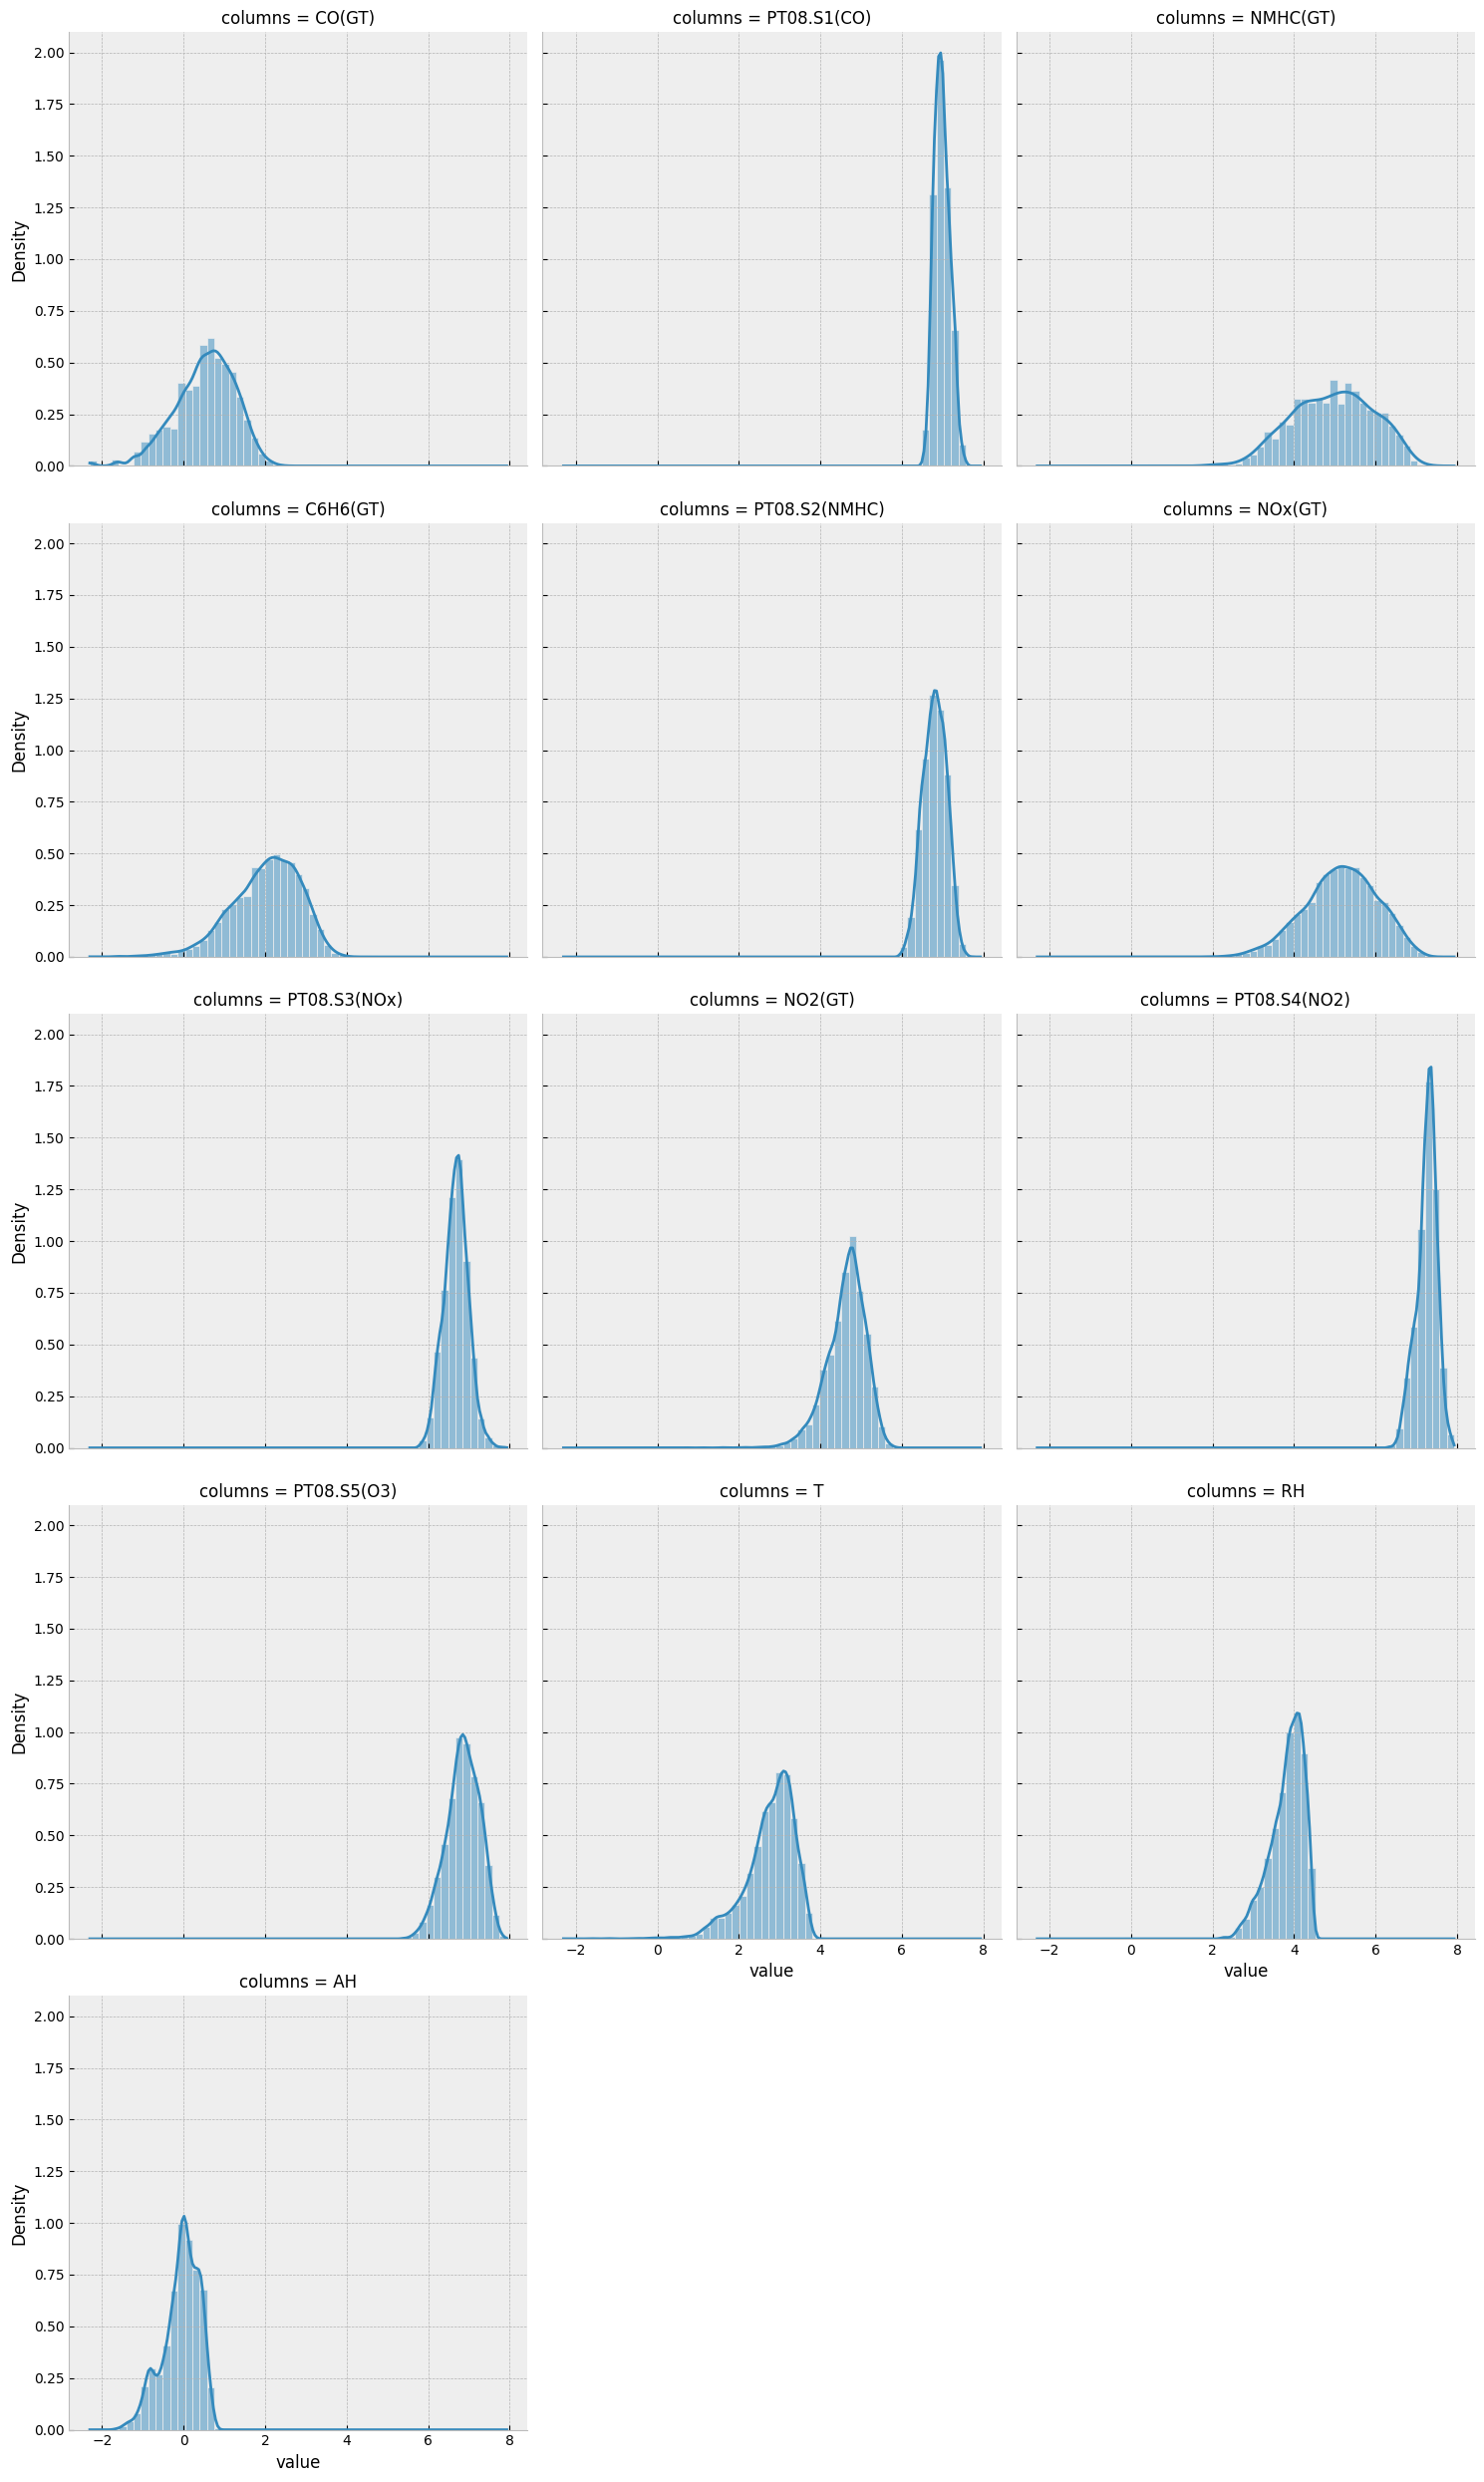

In [ ]:
dfm = np.log(df.iloc[:, 2:15]).melt(var_name='columns')
g = sns.displot(data=dfm, x='value', col='columns', col_wrap=3, common_norm=False, kde=True, stat='density')

Використав IterativeImputer замість SimpleImputer

In [10]:

X_cols = df.iloc[:, 2:15]

imputer = IterativeImputer(
    estimator=ExtraTreesRegressor(n_estimators=10, random_state=42),
    max_iter=10,
    random_state=42
)

X_imputed = imputer.fit_transform(X_cols)

df.iloc[:, 2:15] = X_imputed

print("Кількість пропусків після IterativeImputer:")
print(df.iloc[:, 2:15].isnull().sum())
df.describe()

Кількість пропусків після IterativeImputer (має бути 0):
CO(GT)           0
PT08.S1(CO)      0
NMHC(GT)         0
C6H6(GT)         0
PT08.S2(NMHC)    0
NOx(GT)          0
PT08.S3(NOx)     0
NO2(GT)          0
PT08.S4(NO2)     0
PT08.S5(O3)      0
T                0
RH               0
AH               0
dtype: int64


/usr/local/lib/python3.12/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


,Date,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime,Hour
count,9326,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326,9326.000000
mean,2004-09-22 09:08:45.755951104,2.088321,1101.695132,240.575681,10.072690,940.223729,234.569939,832.266760,109.164647,1457.071488,1027.771574,18.291780,49.335436,1.026376,2004-09-22 20:39:05.828865664,11.505576
min,2004-01-04 00:00:00,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700,2004-01-04 00:00:00,0.000000
25%,2004-05-28 00:00:00,1.000000,941.000000,87.400000,4.600000,742.000000,91.925000,656.000000,74.000000,1238.000000,741.000000,12.000000,36.500000,0.745025,2004-05-28 17:15:00,6.000000
50%,2004-09-15 00:00:00,1.700000,1066.000000,172.400000,8.500000,920.000000,169.000000,804.000000,105.000000,1463.000000,971.000000,17.800000,49.800000,0.998950,2004-09-15 13:30:00,12.000000
75%,2004-12-28 00:00:00,2.800000,1231.000000,303.975000,13.775000,1109.000000,308.000000,961.000000,137.000000,1666.000000,1274.000000,24.100000,62.000000,1.304550,2004-12-28 10:45:00,18.000000
max,2005-12-03 00:00:00,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000,2005-12-03 23:00:00,23.000000
std,NaN,1.434577,214.888722,215.162132,7.323446,262.379270,205.308262,253.882484,47.233508,341.018835,395.250473,8.690275,17.027559,0.397718,NaN,6.920980


In [ ]:
# X = df.iloc[:, 2:15]
# print(X.info())
# imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
# imputer = imputer.fit(X)

# X = imputer.transform(X)
# df.iloc[:, 2:15] = X
# df.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 9326 entries, 0 to 9356
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   CO(GT)         7674 non-null   float64
 1   PT08.S1(CO)    8991 non-null   float64
 2   NMHC(GT)       914 non-null    float64
 3   C6H6(GT)       8991 non-null   float64
 4   PT08.S2(NMHC)  8991 non-null   float64
 5   NOx(GT)        7718 non-null   float64
 6   PT08.S3(NOx)   8991 non-null   float64
 7   NO2(GT)        7715 non-null   float64
 8   PT08.S4(NO2)   8991 non-null   float64
 9   PT08.S5(O3)    8991 non-null   float64
 10  T              8991 non-null   float64
 11  RH             8991 non-null   float64
 12  AH             8991 non-null   float64
dtypes: float64(13)
memory usage: 1020.0 KB
None


,Date,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime,Hour
count,9326,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326,9326.000000
mean,2004-09-22 09:08:45.755951104,1.948552,1095.277182,80.976410,9.850225,936.058653,219.671992,831.811924,110.311602,1457.404568,1015.797126,18.406991,49.373065,1.015586,2004-09-22 20:39:05.828865664,11.505576
min,2004-01-04 00:00:00,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700,2004-01-04 00:00:00,0.000000
25%,2004-05-28 00:00:00,1.000000,941.000000,66.000000,4.000000,742.000000,89.000000,665.000000,85.000000,1241.000000,741.000000,12.000000,36.500000,0.745500,2004-05-28 17:15:00,6.000000
50%,2004-09-15 00:00:00,1.500000,1053.000000,66.000000,7.900000,896.000000,142.000000,795.000000,97.000000,1477.000000,944.000000,18.200000,50.400000,0.979200,2004-09-15 13:30:00,12.000000
75%,2004-12-28 00:00:00,2.600000,1222.000000,66.000000,13.700000,1106.000000,285.000000,961.000000,133.000000,1662.750000,1257.000000,24.100000,61.900000,1.298625,2004-12-28 10:45:00,18.000000
max,2005-12-03 00:00:00,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000,2005-12-03 23:00:00,23.000000
std,NaN,1.389786,214.448078,78.469539,7.413616,262.484785,202.721813,252.882453,44.412483,339.982490,392.990763,8.684313,17.018207,0.399826,NaN,6.920980


/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.12/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


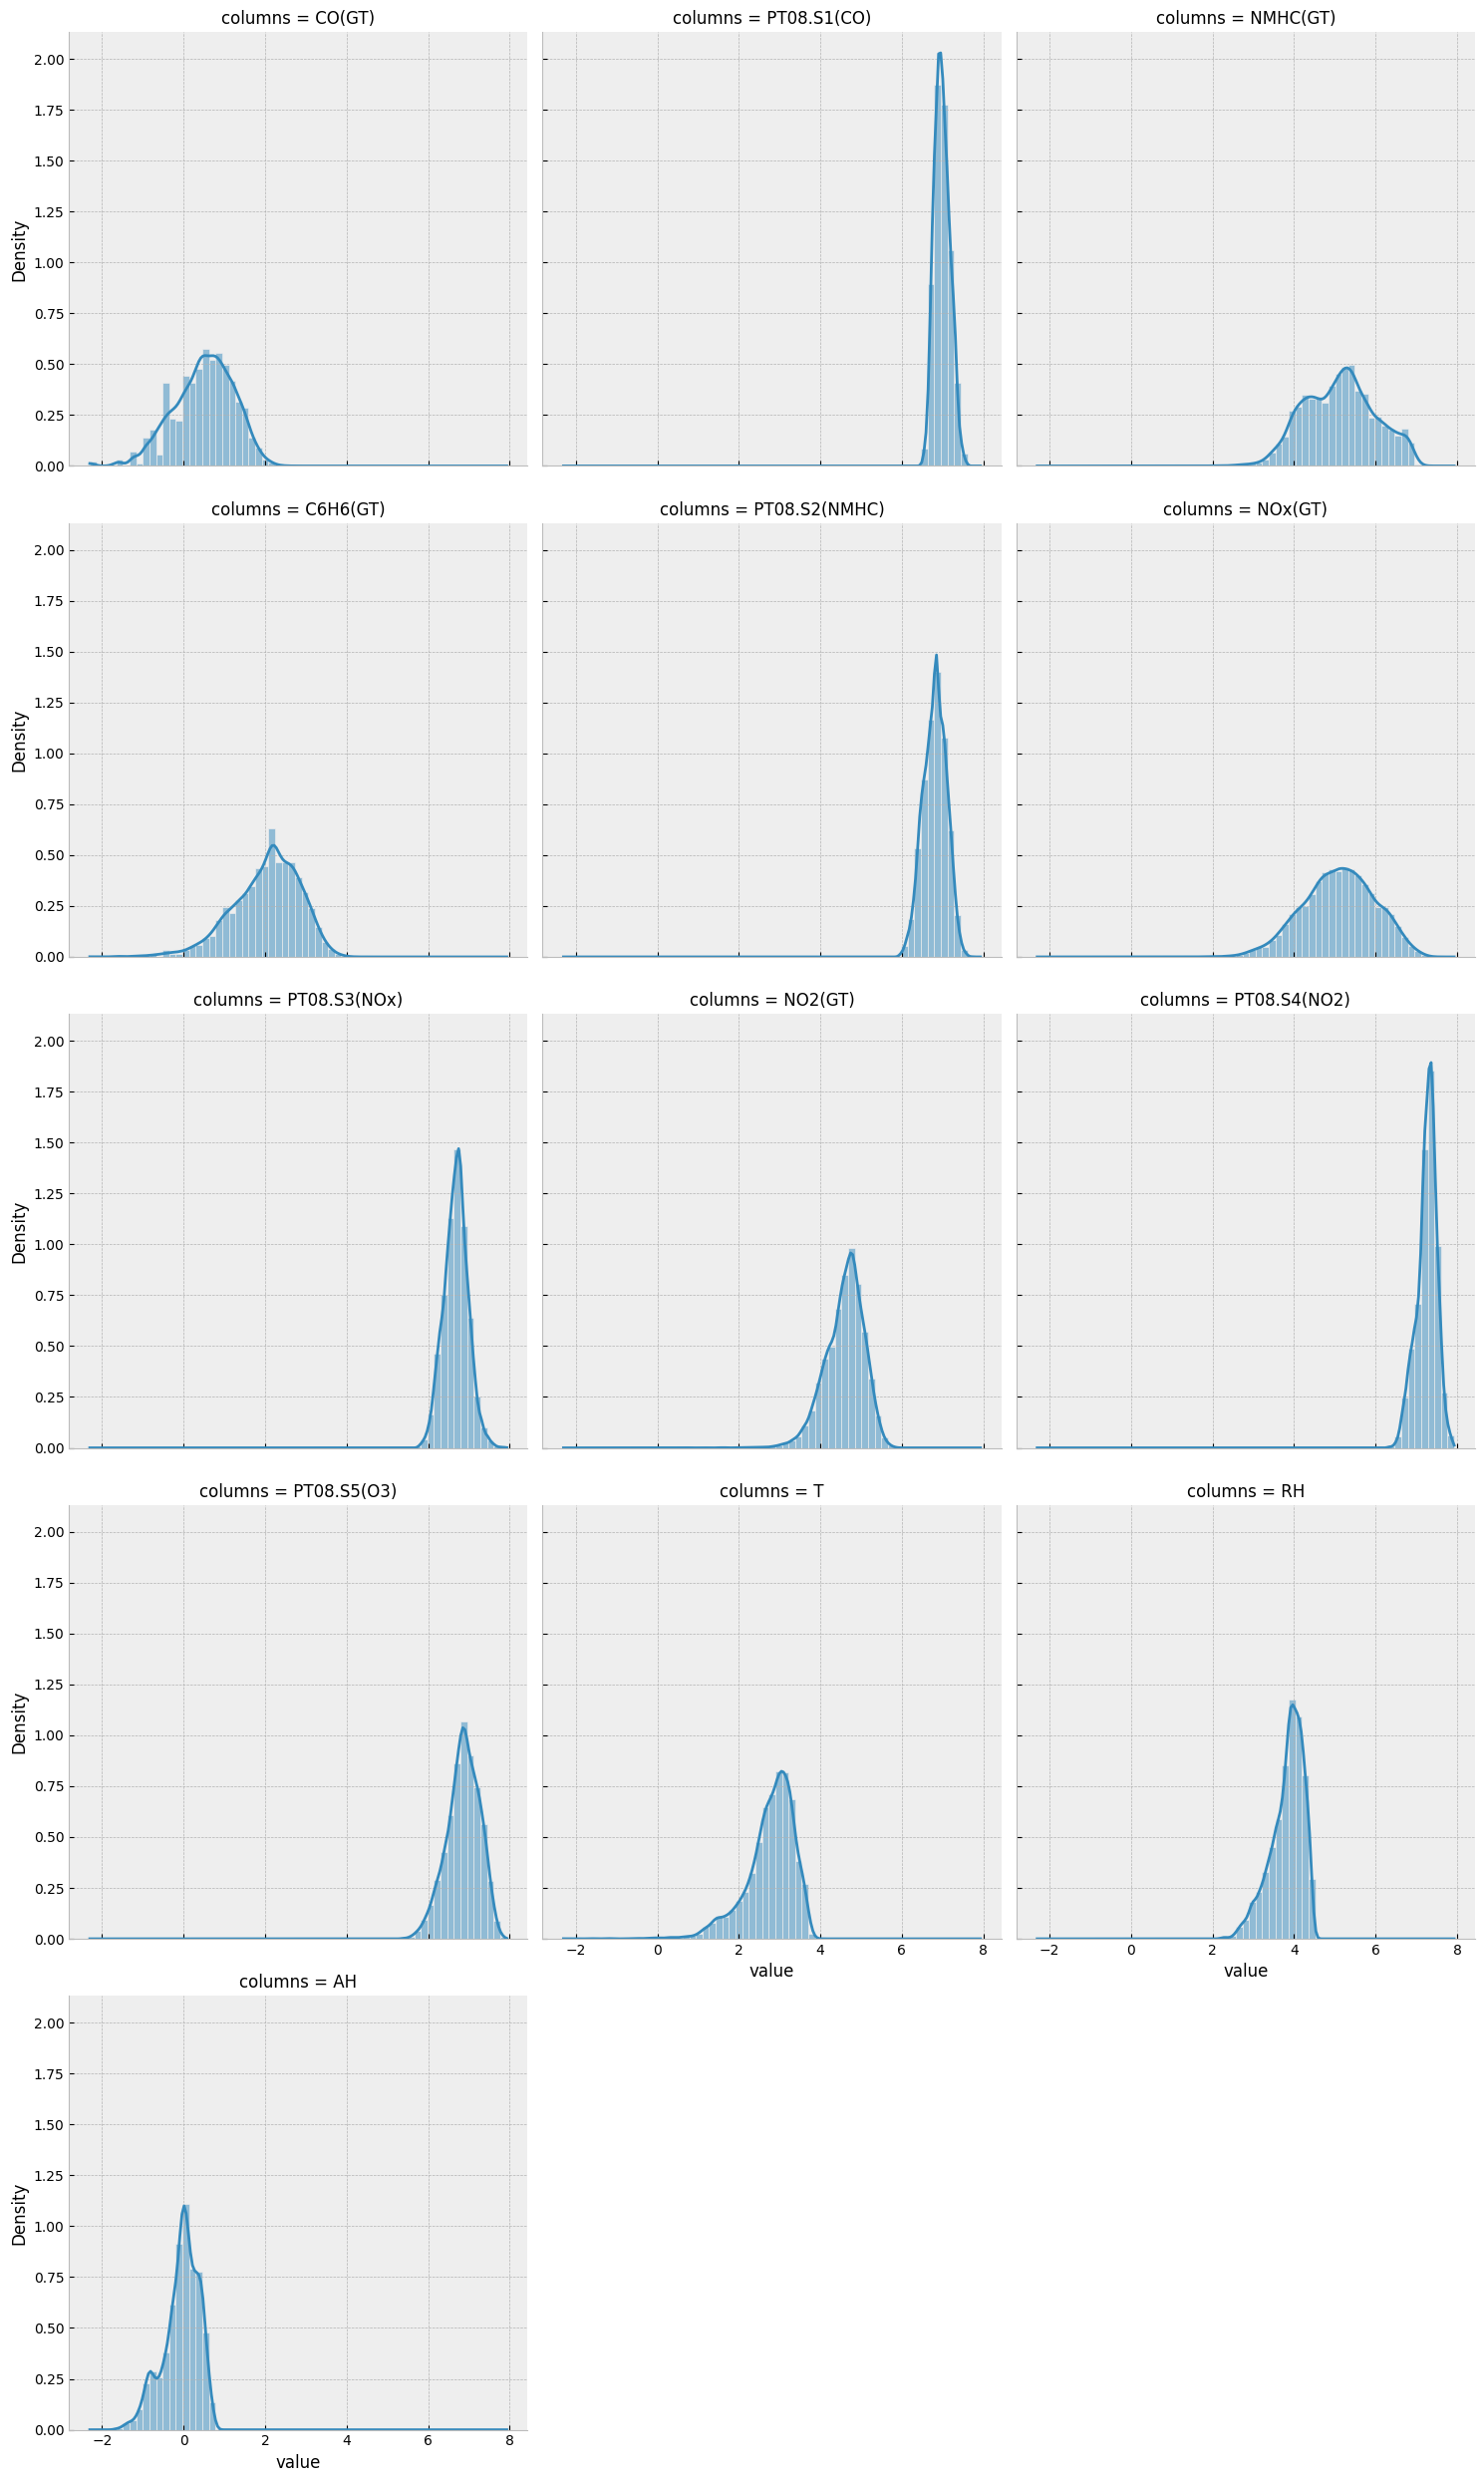

In [11]:
dfm = np.log(df.iloc[:, 2:15]).melt(var_name='columns')
g = sns.displot(data=dfm, x='value', col='columns', col_wrap=3, common_norm=False, kde=True, stat='density')

In [ ]:
df.dtypes

,0
Date,datetime64[ns]
Time,object
CO(GT),float64
PT08.S1(CO),float64
NMHC(GT),float64
C6H6(GT),float64
PT08.S2(NMHC),float64
NOx(GT),float64
PT08.S3(NOx),float64
NO2(GT),float64


In [ ]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime,Hour
0,2004-10-03,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-10-03 18:00:00,18
1,2004-10-03,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-10-03 19:00:00,19
2,2004-10-03,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-10-03 20:00:00,20
3,2004-10-03,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-10-03 21:00:00,21
4,2004-10-03,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-10-03 22:00:00,22


# EDA

Визначемо цільовий та вхідні параметри. Цільовий C6H6(GT).

In [ ]:
# sns.pairplot(df)

Text(0.5, 1.0, 'The relationship between CO(GT) x, C6H6(GT) y')

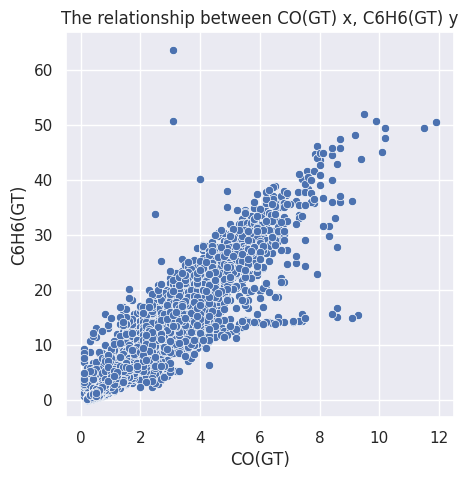

In [12]:
sns.set(rc={'figure.figsize':(5,5)})
plot_co = sns.scatterplot(data=df.loc[:, ['CO(GT)', 'C6H6(GT)']],
                          x='CO(GT)',
                          y='C6H6(GT)')
plot_co.set_title('The relationship between CO(GT) x, C6H6(GT) y')

47.233507661676676


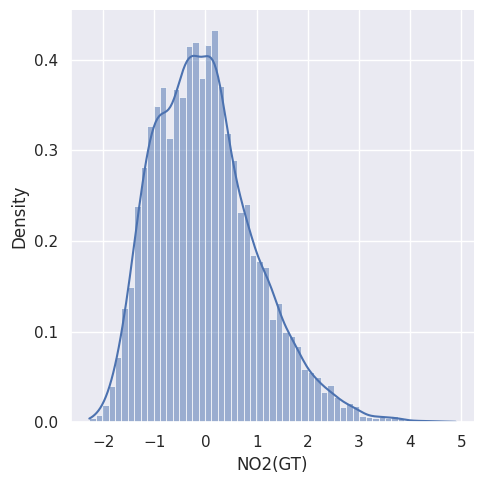

In [13]:
colname="NO2(GT)"
col_sd = df[colname].std()
col_mean = df[colname].mean()
x = (df[colname] - col_mean)/col_sd
print(col_sd)
sns.displot(x=x, kde=True, stat='density', )

Перевіряю скільки аутлаєрів при t = [3, 5]

In [14]:
for t in [3, 3.5, 4, 4.5, 5]:
    n = ((df[colname] - col_mean)/col_sd > t).sum()
    print(f"t={t}, outliers={n}")


t=3, outliers=62
t=3.5, outliers=29
t=4, outliers=9
t=4.5, outliers=4
t=5, outliers=0


In [ ]:
df.describe()

,Date,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime,Hour
count,9326,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326.000000,9326,9326.000000
mean,2004-09-22 09:08:45.755951104,1.948552,1095.277182,80.976410,9.850225,936.058653,219.671992,831.811924,110.311602,1457.404568,1015.797126,18.406991,49.373065,1.015586,2004-09-22 20:39:05.828865664,11.505576
min,2004-01-04 00:00:00,0.100000,647.000000,7.000000,0.100000,383.000000,2.000000,322.000000,2.000000,551.000000,221.000000,-1.900000,9.200000,0.184700,2004-01-04 00:00:00,0.000000
25%,2004-05-28 00:00:00,1.000000,941.000000,66.000000,4.000000,742.000000,89.000000,665.000000,85.000000,1241.000000,741.000000,12.000000,36.500000,0.745500,2004-05-28 17:15:00,6.000000
50%,2004-09-15 00:00:00,1.500000,1053.000000,66.000000,7.900000,896.000000,142.000000,795.000000,97.000000,1477.000000,944.000000,18.200000,50.400000,0.979200,2004-09-15 13:30:00,12.000000
75%,2004-12-28 00:00:00,2.600000,1222.000000,66.000000,13.700000,1106.000000,285.000000,961.000000,133.000000,1662.750000,1257.000000,24.100000,61.900000,1.298625,2004-12-28 10:45:00,18.000000
max,2005-12-03 00:00:00,11.900000,2040.000000,1189.000000,63.700000,2214.000000,1479.000000,2683.000000,340.000000,2775.000000,2523.000000,44.600000,88.700000,2.231000,2005-12-03 23:00:00,23.000000
std,NaN,1.389786,214.448078,78.469539,7.413616,262.484785,202.721813,252.882453,44.412483,339.982490,392.990763,8.684313,17.018207,0.399826,NaN,6.920980


In [ ]:
df[x > 3.5]

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime,Hour
6047,2004-11-17,17.00.00,7.8,1659.0,66.0,35.9,1685.0,1290.0,423.0,133.0,1946.0,2155.0,16.0,41.5,0.7483,2004-11-17 17:00:00,17
6049,2004-11-17,19.00.00,6.6,1549.0,66.0,30.1,1553.0,1148.0,446.0,133.0,1796.0,2032.0,13.0,55.1,0.8240,2004-11-17 19:00:00,19
6051,2004-11-17,21.00.00,4.9,1374.0,66.0,19.0,1268.0,810.0,536.0,133.0,1531.0,1675.0,10.7,62.1,0.7972,2004-11-17 21:00:00,21
6064,2004-11-18,10.00.00,5.6,1446.0,66.0,22.9,1374.0,1195.0,499.0,133.0,1560.0,1818.0,11.4,58.3,0.7868,2004-11-18 10:00:00,10
6065,2004-11-18,11.00.00,4.7,1416.0,66.0,20.2,1302.0,1120.0,526.0,133.0,1471.0,1826.0,13.4,52.8,0.8086,2004-11-18 11:00:00,11
6672,2004-12-13,18.00.00,9.9,1881.0,66.0,50.8,1983.0,1479.0,334.0,133.0,2271.0,2523.0,12.6,55.9,0.8142,2004-12-13 18:00:00,18
7512,2005-01-17,18.00.00,8.6,1683.0,66.0,43.0,1831.0,1216.0,374.0,133.0,1964.0,2331.0,9.2,39.3,0.4573,2005-01-17 18:00:00,18
7840,2005-01-31,10.00.00,3.5,1293.0,66.0,15.1,1153.0,584.0,602.0,133.0,1141.0,1667.0,6.6,34.4,0.3359,2005-01-31 10:00:00,10
7848,2005-01-31,18.00.00,6.1,1414.0,66.0,27.4,1490.0,843.0,488.0,133.0,1433.0,2051.0,10.4,24.7,0.3116,2005-01-31 18:00:00,18
7849,2005-01-31,19.00.00,6.8,1486.0,66.0,30.8,1570.0,954.0,455.0,133.0,1557.0,2179.0,8.6,29.8,0.3344,2005-01-31 19:00:00,19


In [15]:
quantile = df[colname].quantile([0.75])
df.loc[x > 3.5, [colname]] = quantile.iloc[0]

In [ ]:
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,DateTime,Hour
0,2004-10-03,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-10-03 18:00:00,18
1,2004-10-03,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-10-03 19:00:00,19
2,2004-10-03,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-10-03 20:00:00,20
3,2004-10-03,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-10-03 21:00:00,21
4,2004-10-03,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-10-03 22:00:00,22


# Feature Engineering

Цікавий факт: PT08.S2(NMHC) має дуже сильний квадратичний або експоненціальний звязок з C6H6(GT). <br>

<Axes: xlabel='PT08.S2(NMHC)', ylabel='C6H6(GT)'>

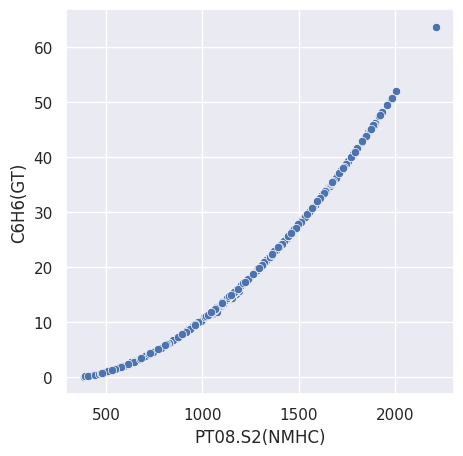

In [16]:
sns.scatterplot(x = df['PT08.S2(NMHC)'], y = df['C6H6(GT)'])

<Axes: xlabel='PT08.S2(NMHC)', ylabel='C6H6(GT)'>

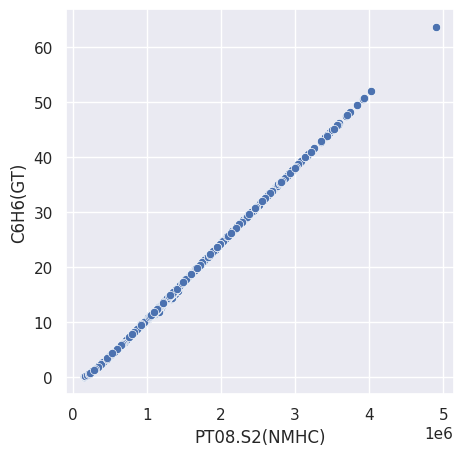

In [17]:
sns.scatterplot(x = df['PT08.S2(NMHC)']**2, y = df['C6H6(GT)'])

Давайте перевіримо кореляцію Пірсона і її p-values для квадрату PT08.S2(NMHC) і C6H6(GT)

In [ ]:
st.pearsonr(df['PT08.S2(NMHC)']**2, df['C6H6(GT)'])

PearsonRResult(statistic=0.9997773201289891, pvalue=0.0)

Як бачимо, маємо майже лінійну залежність і p-value = 0, що означає, що цей звязок є значущим і лінійним. <br>
Згідно з вигомами відсутності мультиколінеарності ми не можемо використовувати квадрат PT08.S2(NMHC)<br>
В іншому випадку нам достатньо лише цього параметру, щоб прогнозувати C6H6(GT) чи наш y.

Додамо день тижня

In [18]:
df['Weekday'] = df['Date'].dt.dayofweek

PearsonRResult(statistic=np.float64(-0.12215833221573698), pvalue=np.float64(2.4314217873159319e-32))


<Axes: xlabel='Weekday', ylabel='C6H6(GT)'>

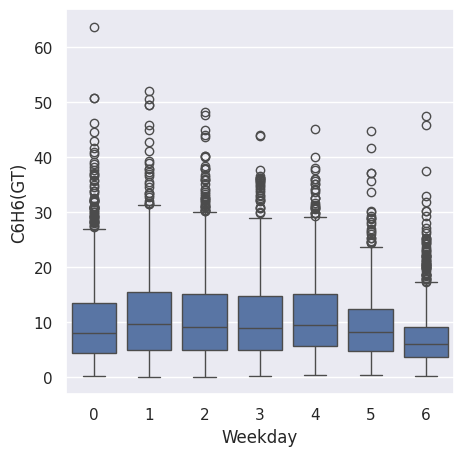

In [19]:
colname = "Weekday"
print(st.pearsonr(df[colname], df['C6H6(GT)']))
sns.boxplot(x = df[colname], y = df['C6H6(GT)'])

Додамо револьверний індекс дня тижня

In [20]:
df['Weekday_revo'] = abs(3 - df['Date'].dt.dayofweek)

Додамо місяць

In [21]:
df['Month'] = df['Date'].dt.month

# Побудуємо моделі

In [22]:
Y_df = df["C6H6(GT)"]
#  Skip "PT08.S2(NMHC)" as it has functional dependency on with the dependent variable "C6H6(GT)"
X_df = df.drop(labels=['C6H6(GT)', 'PT08.S2(NMHC)', 'Date', 'Time', 'DateTime'], inplace=False, axis=1)
X_df_c = X_df.copy()


In [23]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X_df, Y_df, random_state=42)

In [ ]:
# define model
preprocessor = make_column_transformer(

    (Normalizer(), []), # do nothing with the data trasformation
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LinearRegression() # simple linear regression model, do nothing with the dependent variable
    ),
)

In [ ]:

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_df, Y_df, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean MAE: 1.469 (0.041)


In [ ]:
#To improve mode performance, we can use a normalization and apply log to the target variable to turn it approximately into a normal distribution
# define model
preprocessor = make_column_transformer(
    (Normalizer(), X_df.columns), # normalize all features
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LinearRegression(), func=np.log10, inverse_func=sp.special.exp10 # apply log to target variable to turn it approximately into a normal distribution
    ),
)

In [ ]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_df, Y_df, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean MAE: 1.131 (0.038)


↑ We got a little improvement in the model performance. I don't what to do more for improving the model performance.

In [ ]:
# define model
preprocessor = make_column_transformer(

    (Normalizer(), []), # do nothing with the data trasformation
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)

model_lasso = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Lasso(alpha=1.0) # simple linear regression model, do nothing with the dependent variable
    ),
)

In [ ]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_lasso, X_df, Y_df, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean MAE: 1.565 (0.045)


Models such as ridge or lasso work best for a normal distribution of error.

In [ ]:
alphas = np.logspace(-10, 10, 21)

preprocessor = make_column_transformer(
    (Normalizer(), X_df.columns), #
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LassoCV(alphas=alphas), func=np.log10, inverse_func=sp.special.exp10

    ),
)

model.fit(X_train, y_train)
model[-1].regressor_.alpha_

1e-10

LassoCV applies cross validation in order to determine which value of the regularization parameter (alpha) is best suited for prediction.
In our case, the best alpha is 1e-08. if we use model as Lasso(alpha=1e-08) we should get better results than using Lasso(alpha=1.0)

In [ ]:
# define model
preprocessor = make_column_transformer(

    (Normalizer(), []), # do nothing with the data trasformation
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)

model_lasso = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Lasso(alpha=9.999999999999999e-11) # simple linear regression model, do nothing with the dependent variable
    ),
)

In [ ]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_lasso, X_df, Y_df, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean MAE: 1.469 (0.041)


In [ ]:
#Evetually the model requires data transformation.
alpha = 9.999999999999999e-11

preprocessor = make_column_transformer(
    (Normalizer(), X_df.columns), #
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)

model_lasso = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Lasso(alpha=alpha), func=np.log10, inverse_func=sp.special.exp10

    ),
)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_lasso, X_df, Y_df, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean MAE: 1.131 (0.038)


Ridge model

In [26]:
alphas = np.logspace(-10, 10, 21)

preprocessor = make_column_transformer(
    (Normalizer(), X_df.columns), #
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)

model = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=RidgeCV(alphas=alphas), func=np.log10, inverse_func=sp.special.exp10

    ),
)

model.fit(X_train, y_train)
model[-1].regressor_.alpha_

np.float64(1e-07)

In [27]:
#Evetually the model requires data transformation.
alpha = 1e-08

preprocessor = make_column_transformer(
    (Normalizer(), X_df.columns), #
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)

model_ridge = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=Ridge(alpha=alpha), func=np.log10, inverse_func=sp.special.exp10

    ),
)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_ridge, X_df, Y_df, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean MAE: 1.027 (0.034)


In [25]:
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_df, Y_df, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

NameError: name 'model' is not defined

We can check the variability of the coefficients across folds to make sure that there isn't a correlation between the features.

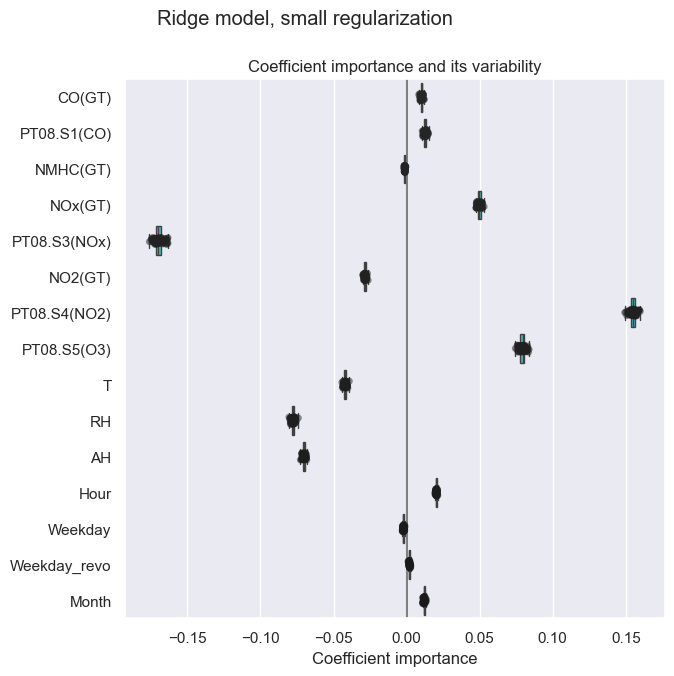

In [ ]:
cv = RepeatedKFold(n_splits=8, n_repeats=10, random_state=0)
model_ridge.fit(X_train, y_train)
cv_model = cross_validate(
    model_ridge,
    X_df,
    Y_df,
    cv=cv,
    return_estimator=True,
    scoring='neg_mean_absolute_error',
    n_jobs=-1
)

coefs = pd.DataFrame(
    [
        est[-1].regressor_.coef_ * est[:-1].transform(X_df.iloc[train_idx]).std(axis=0)
        for est, (train_idx, _) in zip(cv_model["estimator"], cv.split(X_df, Y_df))
    ],
    columns=model_ridge[:-1].get_feature_names_out(), # feature names
)

plt.figure(figsize=(9, 7))
sns.stripplot(data=coefs, orient="h", palette="dark:k", alpha=0.5)
sns.boxplot(data=coefs, orient="h", color="cyan", saturation=0.5, whis=10)
plt.axvline(x=0, color=".5")
plt.xlabel("Coefficient importance")
plt.title("Coefficient importance and its variability")
plt.suptitle("Ridge model, small regularization")
plt.subplots_adjust(left=0.3)

Coefficients do not have a big variance, so they are more or less stable.

Polinomial model

In [24]:
# polinomial model

preprocessor = make_column_transformer(
    (PolynomialFeatures(2), X_df.columns), #
    remainder="passthrough",
    verbose_feature_names_out=False,  # avoid to prepend the preprocessor names
)

model_plnm = make_pipeline(
    preprocessor,
    TransformedTargetRegressor(
        regressor=LinearRegression()

    ),
)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model_plnm, X_df, Y_df, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = np.absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean MAE: 0.628 (0.019)
